In [2]:
import re
import spacy
import string
import collections
import pandas as pd
import seaborn as sns
from textblob import TextBlob
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from sklearn.feature_extraction.text import CountVectorizer


# Scraping from lexisnexis database

In [ ]:
url = 'https://advance.lexis.com/'
driver = webdriver.Chrome(executable_path=strCurrentWorkingDir+"\\chromedriver")
driver.get(url)

time.sleep(3)

# login

uid = driver.find_element_by_id("userid")
uid.send_keys('webminingproject1@gmail.com')

pwd = driver.find_element_by_id("password")
pwd.send_keys('Wmteamproject1@123')
pwd.submit() 

time.sleep(1)

# search for the term

search = driver.find_element_by_xpath('//*[@id="searchTerms"]')
search.send_keys('ethereum')
search.send_keys(Keys.RETURN)

time.sleep(2)

# Dates dropdown

button = driver.find_element_by_xpath('//*[@class="dropdown-toggle fixedWidth"]')
time.sleep(1)
button.click()
time.sleep(1)
button = driver.find_element_by_xpath('//*[@data-value="datedescending"]')
time.sleep(1)
button.click()

# negative news filter

button = driver.find_element_by_xpath('//*[@id="podfiltersbuttonnegativenews"]')
time.sleep(2)
button.click()
time.sleep(3)
negnews1 = driver.find_element_by_xpath('//*[@id="refine"]/ul[10]/li[2]/label')
time.sleep(1)
actions = ActionChains(driver)
actions.move_to_element(negnews1).perform()

negnews1.click()

time.sleep(2)

# news source type filter

button2 = driver.find_element_by_xpath('//*[@id="podfiltersbuttonsource"]')
time.sleep(3)
button2.click()

button2.send_keys(Keys.DOWN,Keys.DOWN,Keys.DOWN)
time.sleep(3)
news_source = driver.find_element_by_xpath('//*[@id="refine"]/ul[5]/li[1]/label')

time.sleep(2)
actions = ActionChains(driver)
actions.move_to_element(news_source).perform()

news_source.click()

titles_ = []
dates_ = []

time.sleep(4)

for j in range(5000):
    try:
        # titles of the news articles
        titles = driver.find_elements_by_xpath('//a[@data-action="title"]')
        titles = driver.find_elements_by_xpath('//a[@data-action="title"]')
        titles_.append([i.text for i in titles])
        time.sleep(1)

        # dates of the news articles(declared twice in order to solve the stalelement exception)
        dates = driver.find_elements_by_xpath('//a[@data-type="nexis-props-date"]')
        dates_.append([i.text for i in dates])
        time.sleep(2)

        # pagination
        pagin = driver.find_element_by_link_text('{}'.format(j+2))
        time.sleep(1)
        actions = ActionChains(driver)
        actions.move_to_element(pagin).perform()
        pagin.click()
    except:
        continue
    
titles = functools.reduce(operator.iconcat, titles_, [])
dates = functools.reduce(operator.iconcat, dates_, [])

driver.close()

In [3]:
df = pd.read_csv('bitcoin_news_titles.csv')

# Data Cleaning

In [4]:
# lowercase each word
df['titles'] = df['titles'].apply(lambda x: x.lower())

# remove digits
df['titles'] = df['titles'].apply(lambda x: re.sub('\w*\d\w*','', x))

# remove punctuations
df['titles'] = df['titles'].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x))

# lemmatization
nlp = spacy.load('en_core_web_sm',disable=['parser', 'ner'])
df['lemmatized'] = df['titles'].apply(lambda x: ' '.join([token.lemma_ for token in list(nlp(x)) if (token.is_stop==False)]))
df['sentiment'] = df['lemmatized'].apply(lambda x: TextBlob(x).sentiment.polarity)

# Word cloud

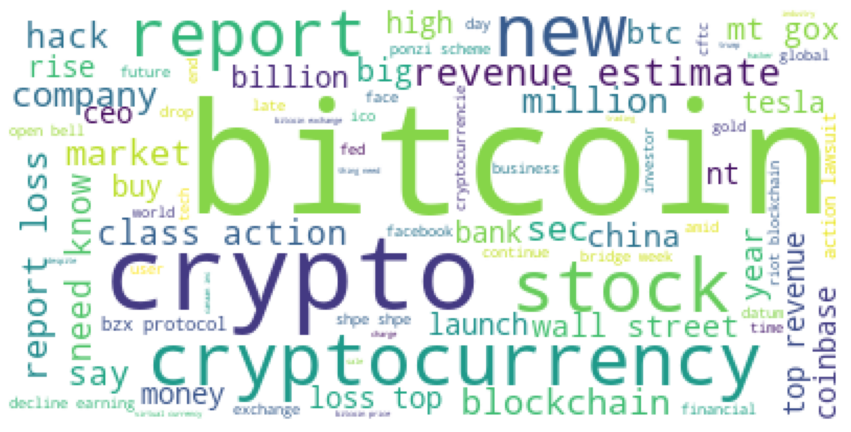

In [40]:
# word cloud of top 80 words from the corpus
# words like bitcoin, cryptocurrency, crypto, stock are visibly more prevelant

cloud = WordCloud(background_color = "white", max_words = 80)
word_cloud = cloud.generate(df['lemmatized'].str.cat(sep = '\n'))
plt.figure(figsize = (15,15))
plt.imshow(word_cloud)
plt.axis("off")
plt.show()

# Sentiment Distribution

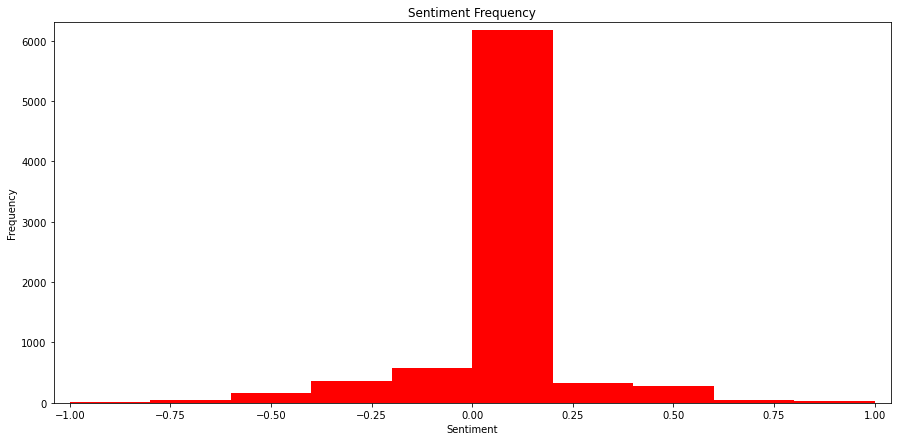

In [25]:
# most of the sentences have a neutral sentiment

plt.figure(figsize = (15,7))
plt.margins(0.02)
plt.xlabel('Sentiment')
plt.ylabel('Frequency')
plt.title('Sentiment Frequency')
plt.hist(df['sentiment'], color = 'red')
plt.show()

# Frequency of lemmatized words

In [13]:
words = []
for i in df['titles']:
    li = i.split()
    for i in li:
        words.append(i)
len(words)

79967

In [23]:
words = []
for i in df['lemmatized']:
    li = i.split()
    for i in li:
        words.append(i)
len(words)

59032

In [24]:
counts = collections.Counter(words)

count_df = pd.DataFrame(counts.most_common(20), columns = ['words', 'count'])
count_df.head()

,words,count
0,bitcoin,1273
1,stock,591
2,report,524
3,earning,511
4,crypto,469


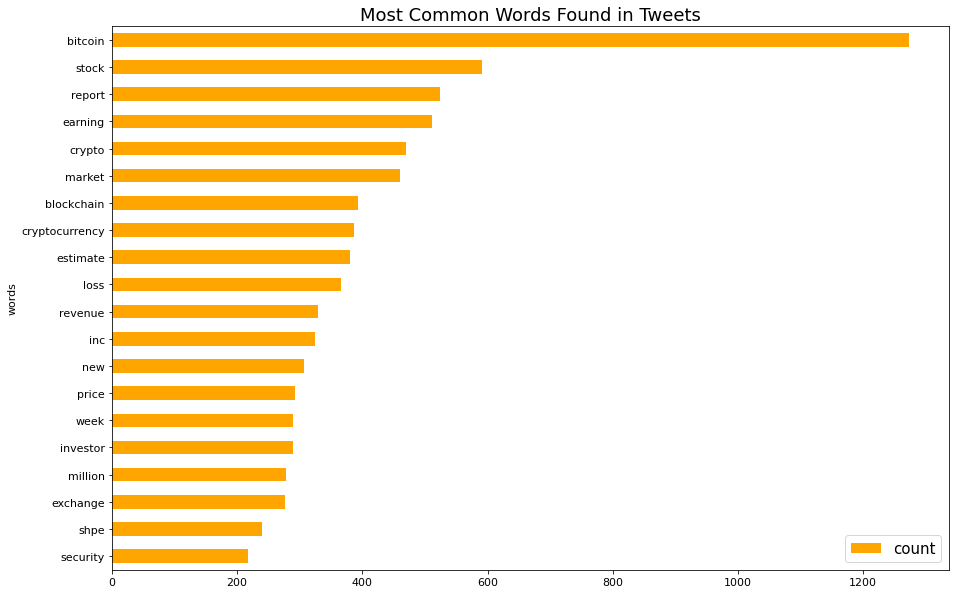

In [26]:
fig, ax = plt.subplots(figsize=(15, 10))
plt.rcParams.update({'font.size': 15})

count_df.sort_values(by = 'count').plot.barh(x = 'words',y = 'count',ax = ax,color = "orange")
ax.set_title("Most Common Words Found in Tweets",)
plt.show()

# Length of sentences distribution

<AxesSubplot:>

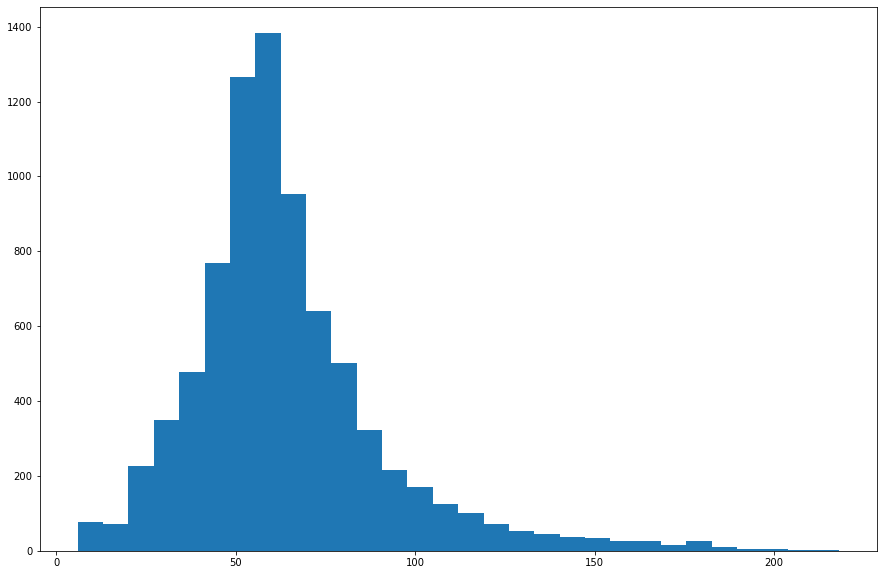

In [28]:
# right skewed as expected since they are news titles not whole paragraphs/articles

df['titles'].str.len().hist(figsize = (15,10), bins = 30, grid = False)

# Length of words distribution

<AxesSubplot:>

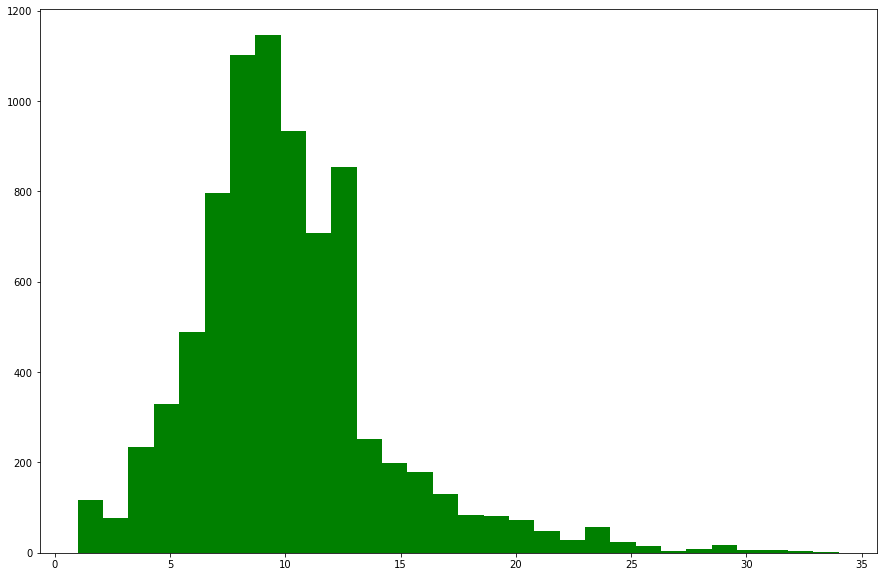

In [29]:
# also right skewed with a mean around 9

df['titles'].str.split().map(lambda x: len(x)).hist(figsize = (15,10), bins = 30, grid = False, color = 'green')

# Bag Of Words

In [37]:
list_of_lemmatized_texts = df['lemmatized'].tolist()
vectorizer = CountVectorizer(min_df=1)
term_doc_matrix = vectorizer.fit_transform(list_of_lemmatized_texts)

In [38]:
df_bow = pd.DataFrame(term_doc_matrix.toarray(), columns=vectorizer.get_feature_names())
result = pd.concat([df, df_bow], axis=1)
result.head()

,dates,titles,lemmatized,sentiment,aal,aaoi,aapl,aaron,aaww,ab,...,zukunftstrends,zum,zumiez,zumz,zuo,zuora,zurich,zurita,zurück,zynga
0,"Oct 24, 2021",newswatch big tech stocks are the markets supe...,newswatch big tech stock market superstar rise...,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"Oct 24, 2021",bzx protocol bzrx price hits on top exchanges,bzx protocol bzrx price hit exchange,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"Oct 24, 2021",bzx protocol price reaches on exchanges bzrx,bzx protocol price reach exchange bzrx,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"Oct 23, 2021",inside the courts an update from skadden secu...,inside court update skadden security litigat...,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"Oct 23, 2021",whats the deal with well everything,s deal,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [39]:
result['loss'].sum(), result['profit'].sum(), result['bitcoin'].sum()

(366, 40, 1273)

# n-gram distribution

In [31]:
def get_top_ngrams(df,n,g):
    vec = CountVectorizer(ngram_range=(g,g)).fit(df)
    bow = vec.transform(df)
    sum_words = bow.sum(axis=0)
    freq = [(word,sum_words[0,i]) for word,i in vec.vocabulary_.items()]
    freq = sorted(freq,key=lambda x:x[1],reverse=True)
    return freq[:n]


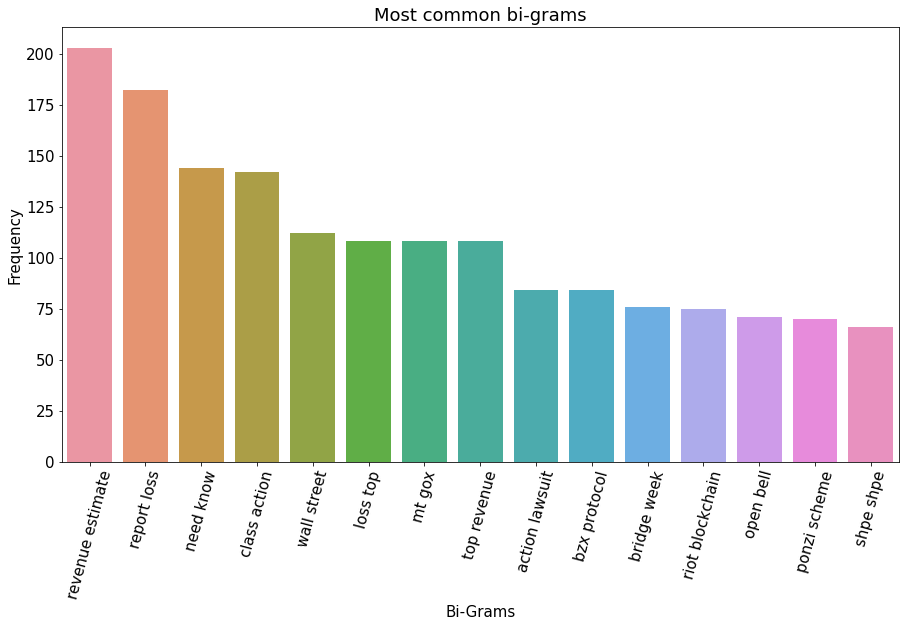

In [39]:
common_ngrams = get_top_ngrams(df['lemmatized'],15,2)
 
df_bigram = pd.DataFrame(common_ngrams,columns=['word','count'])
df_bigram = df_bigram.groupby('word').sum()['count'].sort_values(ascending=False).reset_index()
 
fig,ax = plt.subplots(figsize=(15,8))
fig = sns.barplot(x = 'word',y='count',data=df_bigram,ci = None, ax=ax)
ax.set_title('Most common bi-grams')
ax.set_xlabel('Bi-Grams')
ax.set_ylabel('Frequency')
ax.set_xticklabels(labels=df_bigram['word'], rotation=75)
plt.rcParams.update({'font.size': 15})

plt.show()

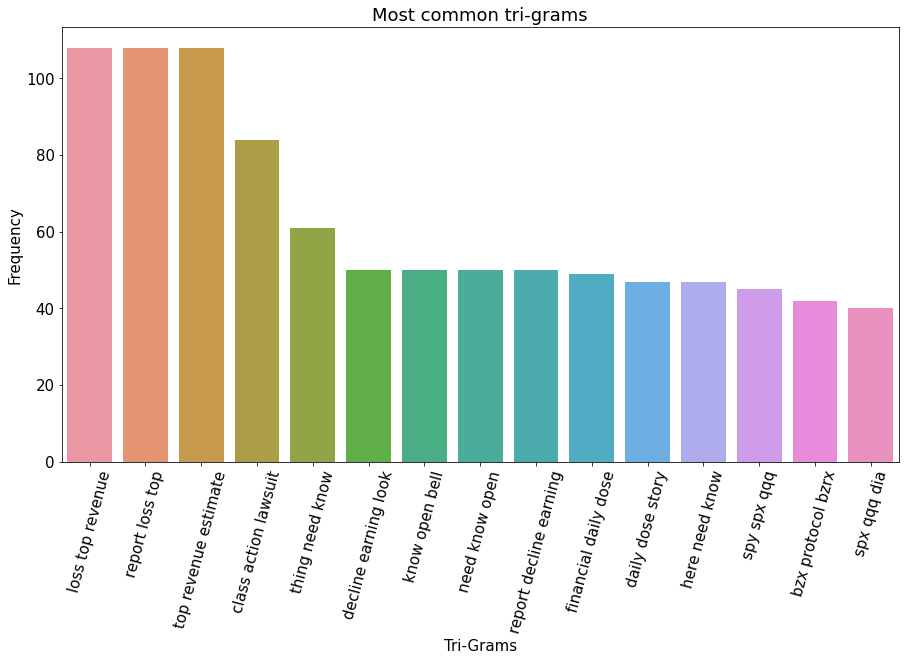

In [38]:
common_ngrams = get_top_ngrams(df['lemmatized'],15,3)
 
df_trigram = pd.DataFrame(common_ngrams,columns=['word','count'])
df_trigram = df_trigram.groupby('word').sum()['count'].sort_values(ascending=False).reset_index()
 
fig,ax = plt.subplots(figsize=(15,8))
fig = sns.barplot(x = 'word',y='count',data=df_trigram,ci = None, ax=ax)
ax.set_title('Most common tri-grams')
ax.set_xlabel('Tri-Grams')
ax.set_ylabel('Frequency')
ax.set_xticklabels(labels=df_trigram['word'], rotation=75)
plt.rcParams.update({'font.size': 15})

plt.show()

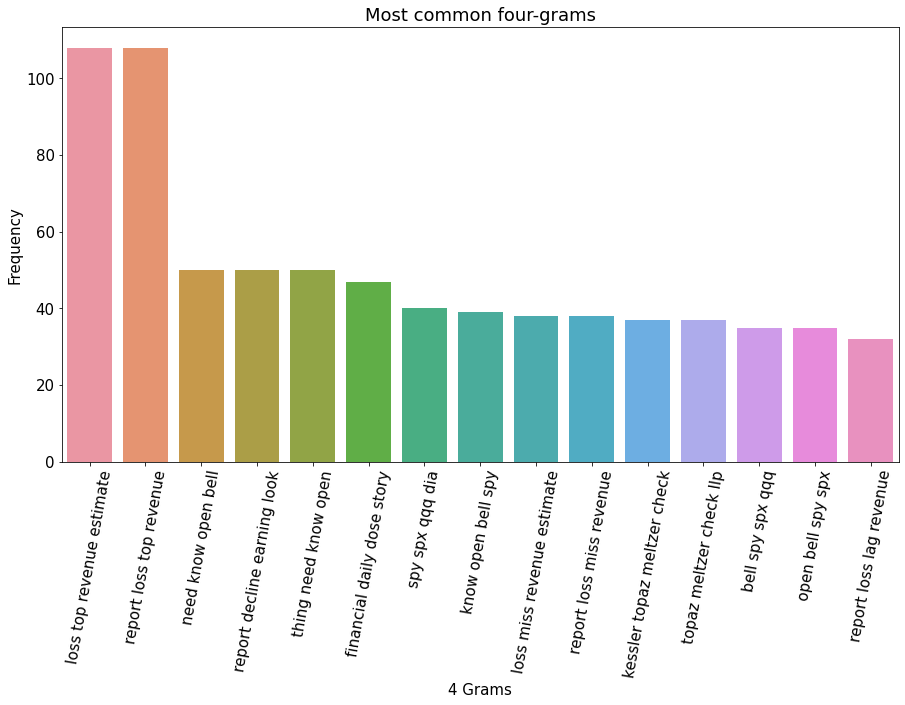

In [37]:
common_ngrams = get_top_ngrams(df['lemmatized'],15,4)
 
df_fourgram = pd.DataFrame(common_ngrams,columns=['word','count'])
df_fourgram = df_fourgram.groupby('word').sum()['count'].sort_values(ascending=False).reset_index()
 
fig,ax = plt.subplots(figsize=(15,8))
fig = sns.barplot(x = 'word',y='count',data=df_fourgram,ci = None, ax=ax)
ax.set_title('Most common four-grams')
ax.set_xlabel('4 Grams')
ax.set_ylabel('Frequency')
ax.set_xticklabels(labels=df_fourgram['word'], rotation=80)
plt.rcParams.update({'font.size': 15})

plt.show()